# Image augmentation strategies:

### Demo data: [Kaggle Cats Vs. Dogs Redux](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

## Part 01 - [Using Keras pre-processing:](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

### Why perform image augmentation?

In order to make the most out of our few training image data, the process of "augmentation" of these images via a number of random transformations is helpful. This process feed the data to the neural network model, so that it would never see twice the exact same picture. The key advantage of implementation such an augmentation strategy is to help prevent overfitting and better generalization by the trained model.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows you to:

* configure random transformations and normalization operations to be done on your image data during training
* instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

### Example implementation in Keras:

In [1]:
try:
    import warnings
    warnings.filterwarnings('ignore')
    from keras.preprocessing.image import ImageDataGenerator
except:
    print ("Please install Keras (cmd: $sudo pip3 install keras) to run this notebook ...")

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Using TensorFlow backend.


### Quick start:

For more information, see the [documentation](https://keras.io/preprocessing/image/).

* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
* shear_range is for randomly applying [shearing transformations](https://en.wikipedia.org/wiki/Shear_mapping)
* zoom_range is for randomly zooming inside pictures
* horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [4]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('../data/cats_dogs/train/cats/cat.1.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)  
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='../data/cats_dogs/preview/', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break

### Keras pre-processing overview:

* The load_img uses Pillow, a complete fork of PIL. This creates a PIL image.
* The img_to_array creates a Numpy array with shape (3, 150, 150).
* The reshape command creates a Numpy array with shape (1, 3, 150, 150).
* The .flow() command below generates batches of randomly transformed images and saves the results to the `../data/cats_dogs/preview/` directory
* The break function prevents the loop from iterating indefinitely.

In [1]:
import os
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt
from IPython.display import Image as PyImage

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = mpl_image.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

def stack_plot(stack_size, folder):
    rows, cols = stack_size, stack_size
    fig,ax = plt.subplots(rows,cols,figsize=[24,24])
    i = 0
    try:
        for filename in os.listdir(folder):
            img = mpl_image.imread(os.path.join(folder, filename))
            ax[int(i/rows),int(i % rows)].imshow(img)
            ax[int(i/rows),int(i % rows)].axis('off')
            i += 1
    except:
        print ("Failed to create a stacked plot ...")
        exit(0)
    plt.show()

### Plotting augmented images:

* Using matplotlib library.
* The load_images function return a Numpy array of all the images in the folder specified in the function.
* The stack_plot generates a stack of images contained inside a specific folder of size: stack_size*stack_size

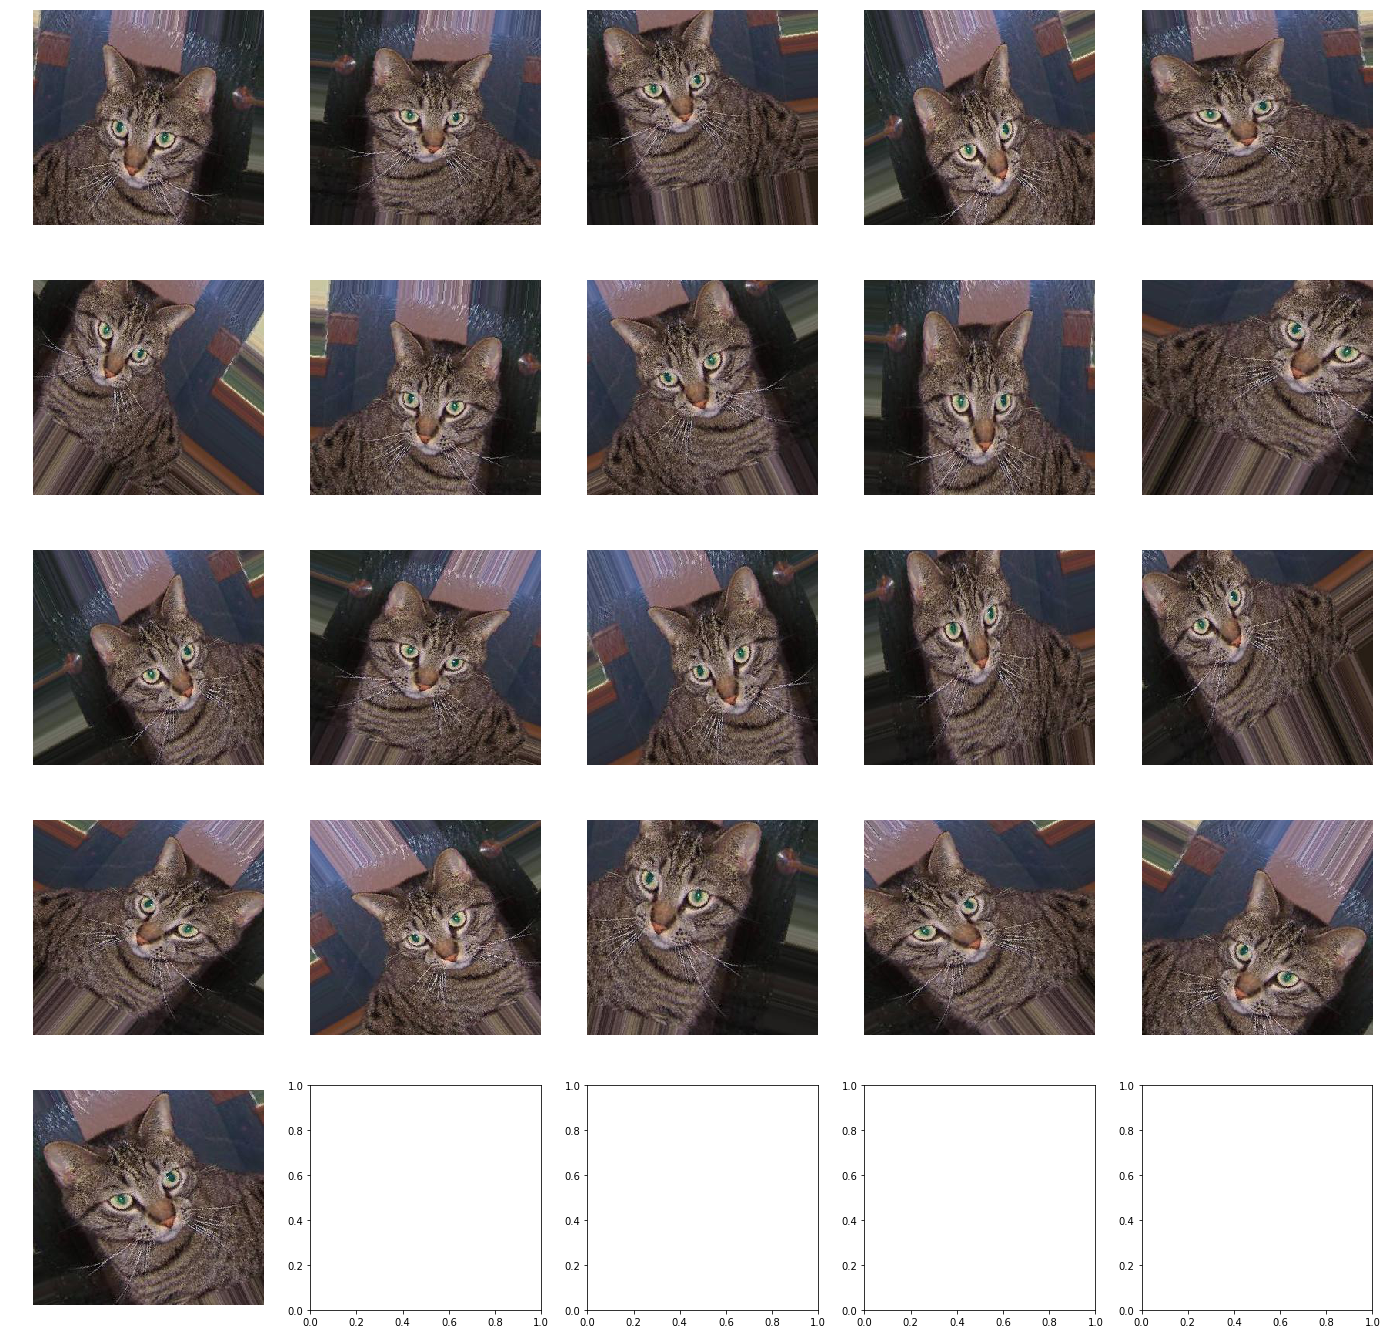

In [2]:
stack_plot(5, '../data/cats_dogs/preview/')

### Implementing a convolutional neural network that uses image augmentation:

#### Importing dependent libraries:

In [ ]:
try:
    from keras.preprocessing.image import ImageDataGenerator
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D
    from keras.layers import Activation, Dropout, Flatten, Dense
    from keras import backend as K
except:
    print ("Failed to load Keras modules. Verify if dependency requirements are satisfied ...")

* Importing preprocessing.image and models functions from Keras
* Importing layers function
* Importing keras backend

#### Initialize some variables:

In [ ]:
img_width, img_height = 150, 150

train_data_dir = '../data/cats_dogs/train/'
validation_data_dir = '../data/cats_dogs/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

* Using img_width, img_height variables for specifying the dimensions of images to be consumed by the neural network
* Initilaizing variables for location pointers to training data, validation data, train data sample size, validation data sample size, number of training epochs, number of images to be processed in each batch
* Specifying a function to adjust input shape of the tensor if the image RGB data format is channels first or channels last

#### Build and compile a neural network:

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

* Building a neural network model using the Sequential format in Keras
* Compile the model using binary cross entropy as the loss function, RMSProp as the optimizer and accuracy as the evaluation metrics

#### Configuring data generators to process and feed the data to the neural network:

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

* The image augmentation configuration for training

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

* Image augmentation configuration to be used for testing
* This generator uses only rescaling

#### Creating train and validation generators:

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

#### Creating a model fit generator function for training the neural network:

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

#### Saving model weights at the end of the training session:

In [ ]:
model.save_weights('../data/cats_dogs/model/first_try.h5')

### Implementing a neural network using transfer learning:

#### Importing dependent libraries:

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

#### Defining and initializing variables:

In [ ]:
# dimensions of our images.
img_width, img_height = 150, 150
top_model_weights_path = '../data/cats_dogs/model/bottleneck_fc_model.h5'
train_data_dir = '../data/cats_dogs/train'
validation_data_dir = '../data/cats_dogs/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

#### Creating a function to save bottleneck features:

In [ ]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('../data/cats_dogs/model/bottleneck_features_train.npy', 'w'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('../data/cats_dogs/model/bottleneck_features_validation.npy', 'w'),
            bottleneck_features_validation)

#### Creating a function to train the top model:

In [ ]:
def train_top_model():
    train_data = np.load(open('../data/cats_dogs/model/bottleneck_features_train.npy'))
    train_labels = np.array(
        [0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))

    validation_data = np.load(open('../data/cats_dogs/model/bottleneck_features_validation.npy'))
    validation_labels = np.array(
        [0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

#### Saving bottleneck features:

In [ ]:
save_bottlebeck_features()

#### Intialize trainig session of the top model and save weights at the end of training:

In [ ]:
train_top_model()

### Fine tuning the model:

In [ ]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

# path to the model weights files.
weights_path = '../data/cats_dogs/model/vgg16_weights.h5'
top_model_weights_path = '../data/cats_dogs/model/bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '../data/cats_dogs/train'
validation_data_dir = '../data/cats_dogs/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

# build the VGG16 network
model = applications.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model.add(top_model)

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

# fine-tune the model
model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)

In [ ]:
model.save_weights('../data/cats_dogs/model/vgg16_tl.h5')

## Part 02 - [Using radial image transformation:](https://arxiv.org/abs/1708.04347)

Deep learning models have a large number of free parameters that must be estimated by efficient training of the models on a large number of training data samples to increase their generalization performance. In real-world applications, the data available to train these networks is often limited or imbalanced. Hojjat Salehinejad et.al  propose a sampling method based on the radial transform in a polar coordinate system for image augmentation. This facilitates the training of deep learning models from limited source data. The pixel-wise transformation implemeted here provides representations of the original image in the polar coordinate system by generating a new image from each pixel. This technique can generate radial transformed images up to the number of pixels in the original image to increase the diversity of poorly represented image classes. Our experiments show improved generalization performance in training deep convolutional neural networks using these radial transformed images. 

In [15]:
from skimage import data
from skimage import io
import numpy as np
import math
import matplotlib.pyplot as plt

def to_gray(img):
    w, h,_ = img.shape
    ret = np.empty((w, h), dtype=np.uint8)
    retf = np.empty((w, h), dtype=np.float)
    imgf = img.astype(float)
    retf[:, :] = ((imgf[:, :, 1] + imgf[:, :, 2] + imgf[:, :, 0])/3)
    ret = retf.astype(np.uint8)
    return ret

def radial_transform(img,w,h):
    shape = im.shape

    new_im = np.zeros(shape)
    print(shape)
    print(len(shape))
    print('w',w)
    print('h',h)
    width = shape[1]
    height = shape[0]
    lens = len(shape)
    for i in range(0,width):
	    xita = 2*3.14159*i/width
	    for a in range(0,height):
		    x = (int)(math.floor(a * math.cos(xita)))
		    y = (int)(math.floor(a * math.sin(xita)))
		    new_y = (int)(h+x)
		    new_x = (int)(w+y)
		    #print(h.dtype)
		    if new_x>=0 and new_x<width:
			    if new_y>=0 and new_y<height:
				    if lens==3:
					    new_im[a,i,0] = (im[new_y,new_x,0]-127.5)/128
					    new_im[a,i,1] = (im[new_y,new_x,1]-127.5)/128
					    new_im[a,i,2] = (im[new_y,new_x,2]-127.5)/128
				    else:
					    new_im[a,i] = (im[new_y,new_x]-127.5)/128
					    new_im[a,i] = (im[new_y,new_x]-127.5)/128
					    new_im[a,i] = (im[new_y,new_x]-127.5)/128
    return new_im

In [16]:
im = io.imread('../data/cats_dogs/preview/cat_0_1511.jpeg')
im = to_gray(im)
h = im.shape[0]
w = im.shape[1]

new_im1 = radial_transform(im,(int)(w/2),(int)(h/2))
new_im2 = radial_transform(im,(int)(w/4),(int)(h/4))
new_im3 = radial_transform(im,(int)(w*0.5),(int)(h*0.75))

#io.imshow(im)
#io.imsave('E:/112.jpg',new_im3)
#io.show()

(374, 500)
2
w 250
h 187
(374, 500)
2
w 125
h 93
(374, 500)
2
w 250
h 280


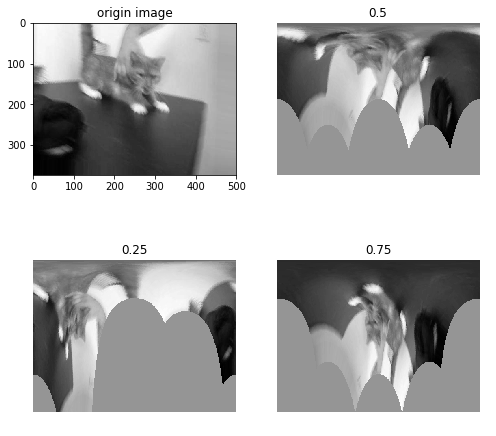

In [17]:
plt.figure(num='cats_dogs',figsize=(8,8))  

plt.subplot(2,2,1)     
plt.title('origin image')  
plt.imshow(im,plt.cm.gray)      

plt.subplot(2,2,2)    
plt.title('0.5')  
plt.imshow(new_im1,plt.cm.gray)     
plt.axis('off')    

plt.subplot(2,2,3)    
plt.title('0.25')  
plt.imshow(new_im2,plt.cm.gray)     
plt.axis('off')    

plt.subplot(2,2,4)    
plt.title('0.75')  
plt.imshow(new_im3,plt.cm.gray)     
plt.axis('off')     

plt.show() 